##Read in library

In [12]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from typing import Tuple, List
import argparse
import math
import yaml

##Read in data

In [ ]:
jkt_shp_file_p = "data/processed/jkt/jkt_district_divisions/jkt_district_divisions.shp"  # Change path if needed
java_shp_file_p = "data/processed/java/westjava_district_divisions/westjava_district_divisions.shp"  # Change path if needed

In [14]:
# Load Data
df_jkt = gpd.read_file(jkt_shp_file_p)
df_java = gpd.read_file(java_shp_file_p)

In [15]:
#combine both
df_combined = gpd.GeoDataFrame(pd.concat([df_jkt, df_java], ignore_index=True))

##First computational grid plot attempt (did not work)

In [16]:
def compute_grid(grid_size: float, df: gpd.GeoDataFrame):
    """
    Computes Grid Points using a fixed grid size
    grid_size : Spacing for the grid points
    df : GeoDataFrame representing the region
    """
    # Get bounding box
    minx, miny, maxx, maxy = df.total_bounds

    # Generate grid points
    x_coords = np.arange(minx, maxx, grid_size)
    y_coords = np.arange(miny, maxy, grid_size)
    grid_points = [Point(x, y) for x in x_coords for y in y_coords]

    # Convert to GeoDataFrame
    grid_gdf = gpd.GeoDataFrame(geometry=grid_points, crs=df.crs)

    # Filter points inside the region
    grid_gdf = grid_gdf[grid_gdf.within(df.unary_union)]

    # Store x coordinates of lat/lon grid points
    x = np.array([(point.x, point.y) for point in grid_gdf.geometry])

    return x, grid_gdf


In [17]:
def pol_pts(df_shp: gpd.GeoDataFrame, grid_pts: gpd.GeoDataFrame):
    """
    Counts the grid points that fall on the regions
    """
    grid_pts = grid_pts.to_crs(df_shp.crs)

    n_pol = len(df_shp.geometry)
    n_pts = len(grid_pts.geometry)

    pl_pt = np.zeros((n_pol, n_pts), dtype=int)
    pt_which_pol = np.zeros(n_pts, dtype=int)

    for i_pol, pol in enumerate(df_shp.geometry):
        for j_pts, pt in enumerate(grid_pts.geometry):
            if pol.contains(pt):
                pl_pt[i_pol, j_pts] = 1
                pt_which_pol[j_pts] = i_pol + 1

    return pl_pt, pt_which_pol


In [ ]:
def plot_grid(df: gpd.GeoDataFrame, grid_pts: gpd.GeoDataFrame, file_name: str):
    """
    Plots grid points on the given region map and saves the figure
    """
    fig, ax = plt.subplots(figsize=(10,10))
    df.plot(ax=ax, edgecolor="black", facecolor="none")
    grid_pts.plot(ax=ax, color="red", markersize=2)
    plt.title("Grid Overlay")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.savefig("plot/" + file_name)
    plt.show()
    print(f"Saving plot as {file_name}...")



In [19]:
def get_points_in_region(df: gpd.GeoDataFrame, grid_pts: gpd.GeoDataFrame):
    """
    Returns an array with points that fall in regions
    """
    pol_pt, pt_which_pol = pol_pts(df, grid_pts)
    pol_sums = np.sum(pol_pt, axis=1)

    print("Regions without points:", [i for i, v in enumerate(pol_sums) if v == 0])

    if any(item == 0 for item in pol_sums):
        print("⚠️ Warning: Some regions have no points! Consider increasing grid density or adjusting extents.")
    else:
        print("✅ At least one point falls in every region!")

    return pol_pt, pt_which_pol

In [20]:
def check_for_min_points(start_value: float, end_value: float, df: gpd.GeoDataFrame):
    """
    Finds the minimum grid size where at least one point falls in every region
    """
    grid_size = start_value

    for _ in range(int((end_value - start_value) / 0.001)):
        grid_pts = compute_grid(grid_size, df)
        pol_pt, _ = pol_pts(df, grid_pts)
        pol_sums = np.sum(pol_pt, axis=1)

        if all(item > 0 for item in pol_sums):
            print(f"Minimum grid size ensuring coverage: {grid_size}")
            return grid_size
        else:
            grid_size += 0.001

    print("No suitable grid size found in given range.")
    return None

#Determine optimal parameters (grid_size) and plot the grid

##Combined region (java + jkt)

In [21]:
grid_size = 0.03
x, grid_pts = compute_grid(grid_size, df_combined)
print(f"Num Grid Points: {grid_pts.shape}") #(3432, 1)

<ipython-input-16-4e89d04ac52c>:19: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_gdf = grid_gdf[grid_gdf.within(df.unary_union)]


Num Grid Points: (3432, 1)


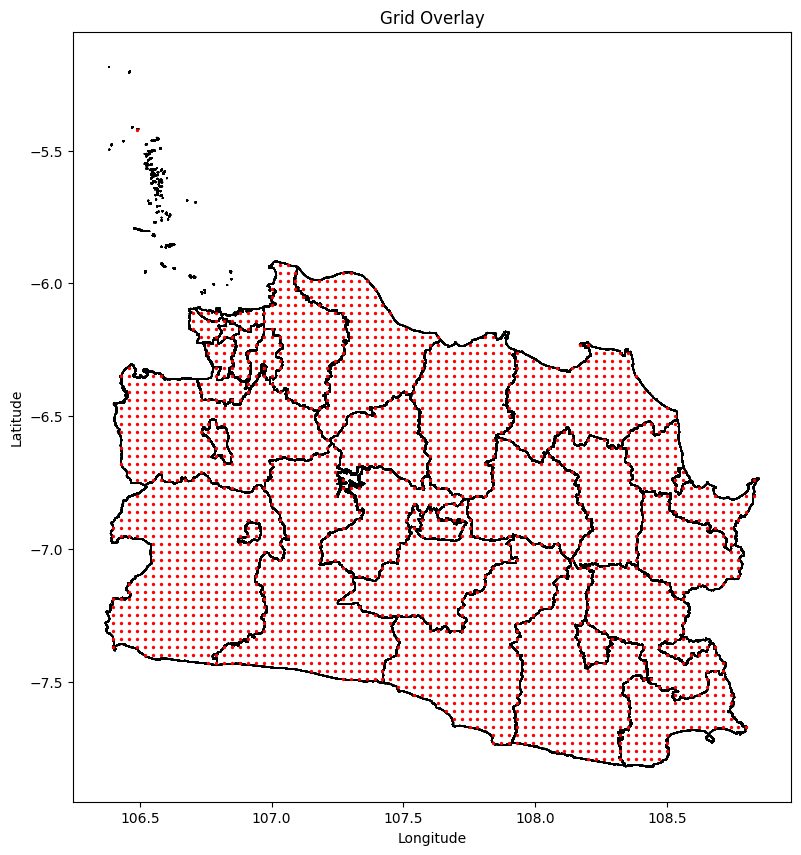

Saving plot as grid_overlay java + jakarta.png...


In [22]:
#try plotting to see how
plot_grid(df_combined, grid_pts, file_name="grid_overlay java + jakarta.png")

In [24]:
# Compute points within regions of both jakarta and java
pol_pts_all, pt_which_pol_all = get_points_in_region(df_combined, grid_pts)

Regions without points: []
✅ At least one point falls in every region!


In [ ]:
#save parameters
np.save("data/processed/lat_lon_x_all", x)
np.save("data/processed/pol_pts_all", pol_pts)
np.save("data/processed/pt_which_pol_all",pt_which_pol_all)

##jakarta only

In [26]:
grid_size = 0.03
x_jkt, grid_pts_jkt = compute_grid(grid_size, df_jkt)
print(f"Num Grid Points JKT: {grid_pts_jkt.shape}")

<ipython-input-16-4e89d04ac52c>:19: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_gdf = grid_gdf[grid_gdf.within(df.unary_union)]


Num Grid Points JKT: (56, 1)


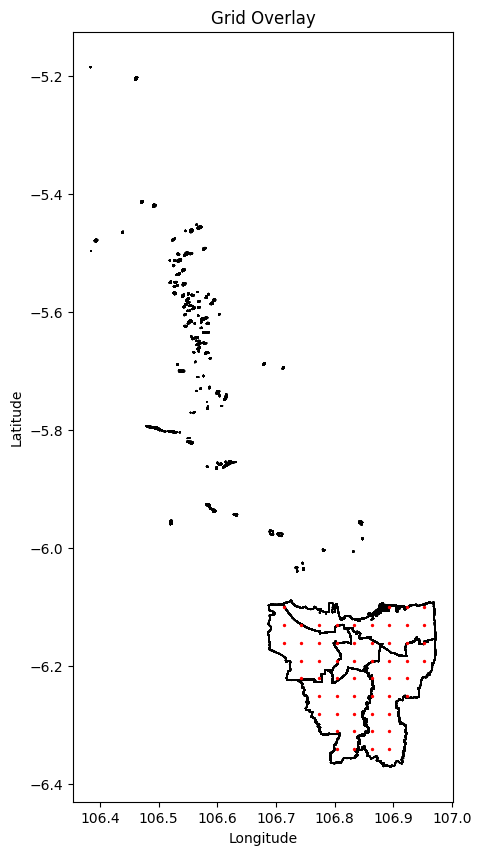

Saving plot as grid_overlay jakarta.png...


In [27]:
#try plotting to see how
plot_grid(df_jkt, grid_pts_jkt, file_name="grid_overlay jakarta.png")

In [28]:
# Compute points within regions of both jakarta and java
pol_pts_jkt, pt_which_pol_jkt = get_points_in_region(df_jkt, grid_pts_jkt)

Regions without points: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
⚠️ Warning: Some regions have no points! Consider increasing grid density or adjusting extents.


In [ ]:
#save parameters
np.save("data/processed/jkt/lat_lon_x_jkt", x_jkt)
np.save("data/processed/jkt/pol_pts_jkt",pol_pts_jkt)
np.save("data/processed/jkt/pt_which_pol_jkt",pt_which_pol_jkt)

##java only

In [30]:
grid_size = 0.03
x_java, grid_pts_java = compute_grid(grid_size, df_java)
print(f"Num Grid Points Java: {grid_pts_java.shape}")

<ipython-input-16-4e89d04ac52c>:19: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_gdf = grid_gdf[grid_gdf.within(df.unary_union)]


Num Grid Points Java: (3371, 1)


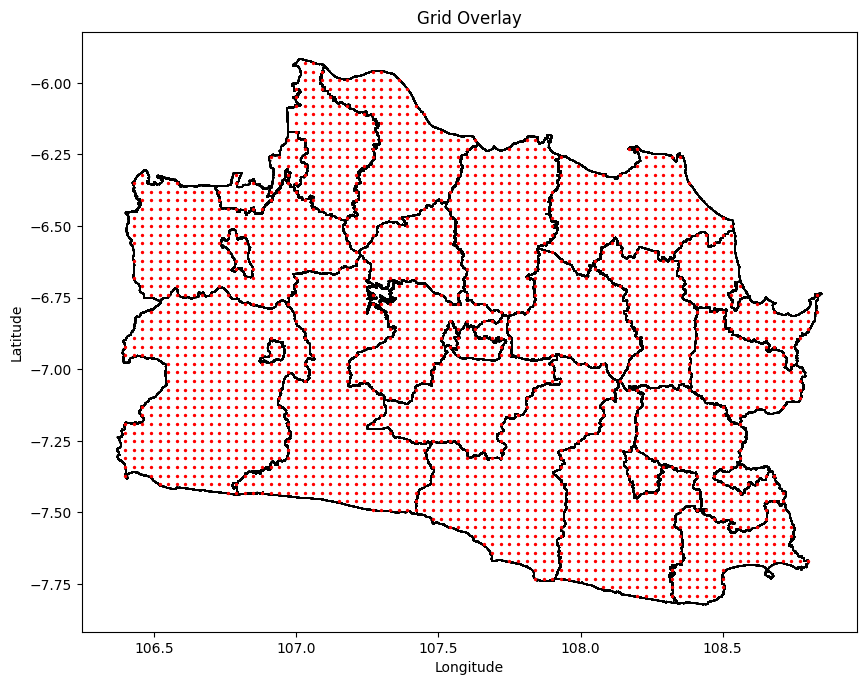

Saving plot as grid_overlay java.png...


In [31]:
#try plotting to see how
plot_grid(df_java, grid_pts_java, file_name="grid_overlay java.png")

In [32]:
# Compute points within regions of both jakarta and java
pol_pts_java, pt_which_pol_java = get_points_in_region(df_java, grid_pts_java)

Regions without points: []
✅ At least one point falls in every region!


In [ ]:
#save parameters
np.save("data/processed/java/lat_lon_x_java", x_java)
np.save("data/processed/java/pol_pts_java",pol_pts_java)
np.save("data/processed/java/pt_which_pol_java",pt_which_pol_java)